In [1]:
import torch
import numpy as np
import sklearn
from sklearn import datasets
import matplotlib.pyplot as plt

In [2]:
# hyperparameters
num_epochs = 5000
batch_size = 64
learning_rate = 0.003

In [3]:
base_mu, base_cov = torch.zeros(2), torch.eye(2)
base_distribution = torch.distributions.multivariate_normal.MultivariateNormal(base_mu, base_cov)

In [4]:
class CouplingLayer(torch.nn.Module):
    def __init__(self, dim, split_dim, hidden_dim):
        super().__init__()
        self.split_dim = split_dim
        self.dim = dim
        self.hidden_dim = hidden_dim
        
        # create sigma and mu nets
        self.sigma_net = torch.nn.Sequential(
            torch.nn.Linear(self.split_dim, self.hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(self.hidden_dim, self.dim - self.split_dim))
        
        self.mu_net = torch.nn.Sequential(
            torch.nn.Linear(self.split_dim, self.hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(self.hidden_dim, self.dim - self.split_dim))
        
    # forward pass f(x)=z
    def forward(self, x, flip=False):
        # split
        x1, x2 = x[:, :self.split_dim], x[:, self.split_dim:]
        
        # flip
        if flip:
            x1, x2 = x2, x1
        
        # pass x1 through nets
        sigma = self.sigma_net(x1)
        mu = self.mu_net(x1)
        # compute z
        z1 = x1
        z2 = x2 * torch.exp(sigma) + mu
        
        z = torch.cat([z1, z2], dim=-1)
        
        log_pz = base_distribution.log_prob(z)
        log_jacobian = sigma.sum(-1)
        
        return z, log_pz, log_jacobian
    
    def inverse(self, z, flip=False):
        z1, z2 = z[:, :self.split_dim], z[:, self.split_dim:]
        # flip
        if flip:
            z1, z2 = z2, z1
            
        # compute the inverse
        x1 = z1
        x2 = (z2 - self.mu_net(z1)) * torch.exp(-self.sigma_net(z1))
        
        x = torch.cat([x1, x2], dim=-1)
        
        return x
        

In [5]:
class Flow(torch.nn.Module):
    def __init__(self, dim, split_dim, hidden_dim, num_layers):
        super().__init__()
        self.num_layers = num_layers
        self.layers = torch.nn.ModuleList([CouplingLayer(dim, split_dim, hidden_dim) for _ in range(self.num_layers)])
        self.flips = [True if i%2==0 else False for i in range(self.num_layers)]
        
    def forward(self, x):
        log_jacobians = []
        
        for layer, flip in zip(self.layers, self.flips):
            x, log_pz, log_jacobian = layer(x, flip)
            log_jacobians.append(log_jacobian)
            
        return x, log_pz, sum(log_jacobians)

    def inverse(self, z):
        for layer, flip in zip(reversed(self.layers), reversed(self.flips)):
            z = layer.inverse(z, flip)
        
        return z

In [6]:
flow = Flow(2, 1, 128, 3)
optim = torch.optim.Adam(flow.parameters(), lr=learning_rate)

In [7]:
losses = []
for epoch in range(num_epochs):

    # get data 
    x, _ = datasets.make_moons(n_samples=batch_size, noise=.05)
    x = torch.from_numpy(sklearn.preprocessing.StandardScaler().fit_transform(x)).float()

    optim.zero_grad()
    z, log_pz, log_jacobian = flow(x)
    loss = (-log_pz - log_jacobian).mean()
    losses.append(loss)

    loss.backward()
    optim.step()

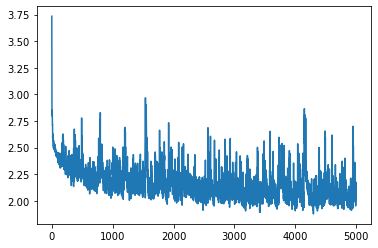

In [8]:
plt.plot(losses)

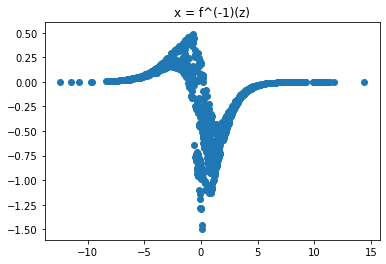

In [9]:
z = base_distribution.rsample(sample_shape=(1000,))
x_hat = flow.inverse(z).detach().numpy()
plt.scatter(x_hat[:, 0], x_hat[:, 1])
plt.title('x = f^(-1)(z)')
plt.show()

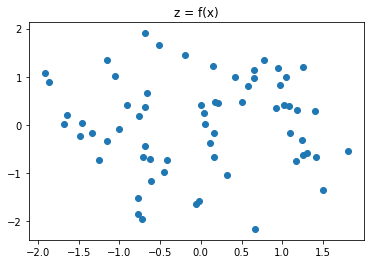

In [10]:
n_samples = 1000
X, _ = datasets.make_moons(n_samples=n_samples, noise=.05)
X = torch.from_numpy(sklearn.preprocessing.StandardScaler().fit_transform(X)).float()
z, _, _ = flow(x)
z = z.detach().numpy()
plt.scatter(z[:, 0], z[:, 1])
plt.title("z = f(x)")
plt.show()